In [1]:
# MakeTidy.py
# Take Steel subsector consumption data from the 7th and reshape in Tidy format
# https://stackoverflow.com/questions/45066873/pandas-melt-with-multiple-value-vars

# import math and data table functions
import numpy as np
import pandas as pd
import os
import datetime as dt

print("Script started. -- Current date/time:", dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# create directories for modified and results data
paths = {'path1': 'modified',
         'path2': 'results'}

for key, value in paths.items(): 
        try:
            os.makedirs(value)
        except OSError:
            print (" ")
        else:
            print ("Successfully created the directory %s " % value)

# read in raw steel data
RawSteelData = pd.read_csv(r'data/IS_production.csv')
RawSteelData.head()

# Replace missing numbers with NaN
# BD, HKC, PNG do not have steel production, set 2018 production value 1 as dummy and backfill the historical numbers for later regression
RawSteelData.replace (0,np.NaN,inplace=True)

# Backfill the NaN with numbers
RawSteelData = RawSteelData.bfill(axis = 'columns')

# using melt to make a tidy set with multiple measured variables - see Table 12 in Tidy Data paper
TidySteel = pd.melt(RawSteelData, id_vars=['Economy'], var_name='Year')
TidySteel.rename(columns={'value':'SteelProduction'}, inplace=True)

# replace economies using APEC approved abbreviations
EconomyNames = {
    '01_AUS':'AUS',
    '02_BD':'BD',
    '03_CDA':'CDA',
    '04_CHL':'CHL',
    '05_PRC':'PRC',
    '06_HKC':'HKC',
    '07_INA':'INA',
    '08_JPN':'JPN',
    '09_ROK':'KOR',
    '10_MAS':'MAS',
    '11_MEX':'MEX',
    '12_NZ':'NZ',
    '13_PNG':'PNG',
    '14_PE':'PE',
    '15_RP':'RP',
    '16_RUS':'RUS',
    '17_SIN':'SIN',
    '18_CT':'CT',
    '19_THA':'THA',
    '20_USA':'USA',
    '21_VN':'VN'}

TidySteel.replace(EconomyNames, inplace=True)

# write to csv
TidySteel.to_csv(r'modified/TidySteel.csv', index=False)

print("Results are saved. -- Current date/time:", dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Script started. -- Current date/time: 2020-10-19 14:23:20
 
 
Results are saved. -- Current date/time: 2020-10-19 14:23:20


In [2]:
# createdatasets.py
# join together GDP, population, and Production

# import math and data table functions
import subprocess

print("Script started. -- Current date/time:", dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# read data from csv and store as dataframe
TidySteel = pd.read_csv(r'modified\TidySteel.csv')
GDP8thHistorical = pd.read_csv(r'..\Macro\results\GDP8thHistorical.csv')
Pop8thHistorical = pd.read_csv(r'..\Macro\results\Pop8thHistorical.csv')

# combine datasets
SteelHistorical = pd.merge(GDP8thHistorical, TidySteel, how='left', on=['Economy','Year'])
SteelHistorical = pd.merge(SteelHistorical,Pop8thHistorical,how='left',on=['Economy','Year'])

# Replace negative numbers with NaN
# Instead of dropping NaN, 'impute' the values by using mean, median, min, etc
# this replaces the NaN for BD, PNG, HK and RUS with min values across all economies
# Note that the BD, PNG values are too high - need to impute by economy
# SteelHistorical.loc[SteelHistorical['SteelProduction'] < 0,'SteelProduction'] = np.NaN
# SteelHistorical.fillna(SteelHistorical[['SteelProduction']].min(), inplace=True)

# i = SteelHistorical[['SteelProduction']].min()
# SteelHistorical.loc[SteelHistorical['Economy'].isin(['BD','HKC','PNG'])] = SteelHistorical.loc[SteelHistorical['Economy'].isin(['BD','HKC','PNG'])].fillna(i)
# j = SteelHistorical.loc[SteelHistorical['Economy']=='RUS','SteelProduction'].mean()
# SteelHistorical.loc[SteelHistorical['Economy'].isin(['RUS'])] = SteelHistorical.loc[SteelHistorical['Economy'].isin(['RUS'])].fillna(j)

# combine future GDP and population, drop the world value
GDP8thFuture = pd.read_csv(r'..\Macro\results\GDP8thFuture.csv')
Pop8thFuture = pd.read_csv(r'..\Macro\results\Pop8thFuture.csv')

GDPPop8thFuture = pd.merge(GDP8thFuture,Pop8thFuture,how='left',on=['Economy','Year']).reset_index(drop=True)

# save dataframes to csv
SteelHistorical.to_csv(r'modified\SteelHistorical.csv', index=False)
GDPPop8thFuture.to_csv(r'modified\GDPPop8thFuture.csv', index=False)

print("Results are saved. -- Current date/time:", dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Script started. -- Current date/time: 2020-10-19 14:26:04
Results are saved. -- Current date/time: 2020-10-19 14:26:04


In [3]:
# ComputeFeatures.py
# compute per capita and natural logs for regression

print("Script started. -- Current date/time:", dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# read datasets from csv
SteelHistorical = pd.read_csv(r'modified/SteelHistorical.csv')
GDPPop8thFuture = pd.read_csv(r'modified/GDPPop8thFuture.csv')

# compute per capita then take natural logs
SteelHistorical['GDPpercap'] = SteelHistorical['GDP'].div(SteelHistorical['Population'])
SteelHistorical['PROpercap'] = SteelHistorical['SteelProduction'].div(SteelHistorical['Population'])

SteelHistorical['lnGDPpercap'] = np.log(SteelHistorical['GDPpercap'])
SteelHistorical['lnPROpercap'] = np.log(SteelHistorical['PROpercap'])

GDPPop8thFuture['GDPpercap'] = GDPPop8thFuture['GDP'].div(GDPPop8thFuture['Population'])
GDPPop8thFuture['lnGDPpercap'] = np.log(GDPPop8thFuture['GDPpercap'])

# write prepared data to csv
SteelHistorical.to_csv(r'modified/SteelHistoricalPrepared.csv', index=False)   
GDPPop8thFuture.to_csv(r'modified/GDPPop8thFuturePrepared.csv', index=False)

print("Results are saved. -- Current date/time:", dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Script started. -- Current date/time: 2020-10-19 14:27:34
Results are saved. -- Current date/time: 2020-10-19 14:27:34


In [6]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# define functions to perform regressions and predictions, and to plot results
# loop over economy-model pairs to fit regression
def run_regression(models, economies, df, x, y):
        for economy, model in models.items():
                (model.fit(df.loc[economy, x],
                    df.loc[economy, y]))
        return models            

# create function for performing prediction and writing results
# loop over economy-model pairs to make prediction and write prediction to csv, one for each economy
def run_prediction(models, economies, df, ResultsColumn):
        df_list =[]
        # run predictions
        for economy, model in models.items():
                prediction = model.predict(df.loc[economy,:])
                df_name = pd.DataFrame(np.exp(prediction), columns=ResultsColumn)
                df_name['Economy'] = economy
                df_list.append(df_name)
        
        # combine individual economy dataframes to one dataframe
        dfResults = pd.concat(df_list, sort=True).reset_index(drop=True)

        # add year column
        df_years = df.reset_index().sort_values(by=['Economy','Year']).reset_index(drop=True).drop(['lnGDPpercap'], axis=1)
        # i had problem with merging. There might be an actual issue here. Worth checking.
        df_merged = pd.merge(dfResults,df_years, how='left', left_index=True, right_index=True)
        df_merged = df_merged.drop('Economy_y', axis=1)

        # rename columns
        #df_merged = df_merged[['Economy_x','Year']].reset_index(drop=True)
        df_merged.rename(columns={'Economy_x':'Economy'}, inplace=True)
        return df_merged

# define function to plot using matplotlib
def plot_results(economies, df1, df2, figurename, PlotColumns, Plotylabel):
    fig = plt.figure(figsize=[16,12])
    plt.style.use('tableau-colorblind10')    
    for economy,num in zip(economies, range(1,22)):
        print('Creating plot for %s...' %economy)
        df11=df1[df1['Economy']==economy]
        df21=df2[df2['Economy']==economy]
        ax = fig.add_subplot(3,7,num)
        ax.plot(df11['Year'], df11[PlotColumns])
        ax.plot(df21['Year'], df21[PlotColumns])
        ax.set_title(economy)
        
        plt.xlim(1980,2050)
        plt.ylim(0,1000000)  
        
        # add y-axis label
        plt.ylabel(Plotylabel)    
        
        # add tight layout function
        plt.tight_layout()
    # show graphic
    plt.show()
    fig.savefig(figurename,dpi=200)
    print('Figure saved as %s' % figurename)

def plot2(economies, df, figurename, Plotylabel, sharex, sharey):
    
    # Create the 'figure'
    plt.style.use('tableau-colorblind10')
    
    # multiple line plot
    fig, axes = plt.subplots(nrows=3, ncols=7, sharex=False, sharey=False, figsize=(16,12))
    for ax, economy,num in zip(axes.flatten(), economies, range(1,22)):
        print('Creating plot for %s...' %economy)
        df11=df[df['Economy']==economy]
    
        for column in df11.drop(['Economy','Year'], axis=1):
            ax.plot(df11['Year'], df11[column], marker='', linewidth=1.5, label=economy)
            ax.set_title(economy)
            ax.set_ylabel(Plotylabel)
        # Same limits for everybody!
        ax.set_ylim(0,1000000)   
        ax.label_outer()
    
    #plt.tight_layout()
    fig.legend( list(df.drop(['Economy','Year'], axis=1)), bbox_to_anchor=(0,0,1,0.25), loc='lower center', ncol=9)
    fig.savefig(figurename,dpi=200)
    print('Figure saved as %s' % figurename)
    print('Preparing to show the figure...')
    plt.show()

Script started. -- Current date/time: 2020-10-19 14:52:04

Generated regression. Please wait for plotting.

Results are saved. -- Current date/time: 2020-10-19 14:52:04
Preparing to show the figure...
Creating plot for AUS...
Creating plot for BD...
Creating plot for CDA...
Creating plot for CHL...
Creating plot for PRC...
Creating plot for HKC...
Creating plot for INA...
Creating plot for JPN...
Creating plot for KOR...
Creating plot for MAS...
Creating plot for MEX...
Creating plot for NZ...
Creating plot for PNG...
Creating plot for PE...
Creating plot for RP...
Creating plot for RUS...
Creating plot for SIN...
Creating plot for CT...
Creating plot for THA...
Creating plot for USA...
Creating plot for VN...
Figure saved as results\Industry\steel\steel production.png
Preparing to show the figure...


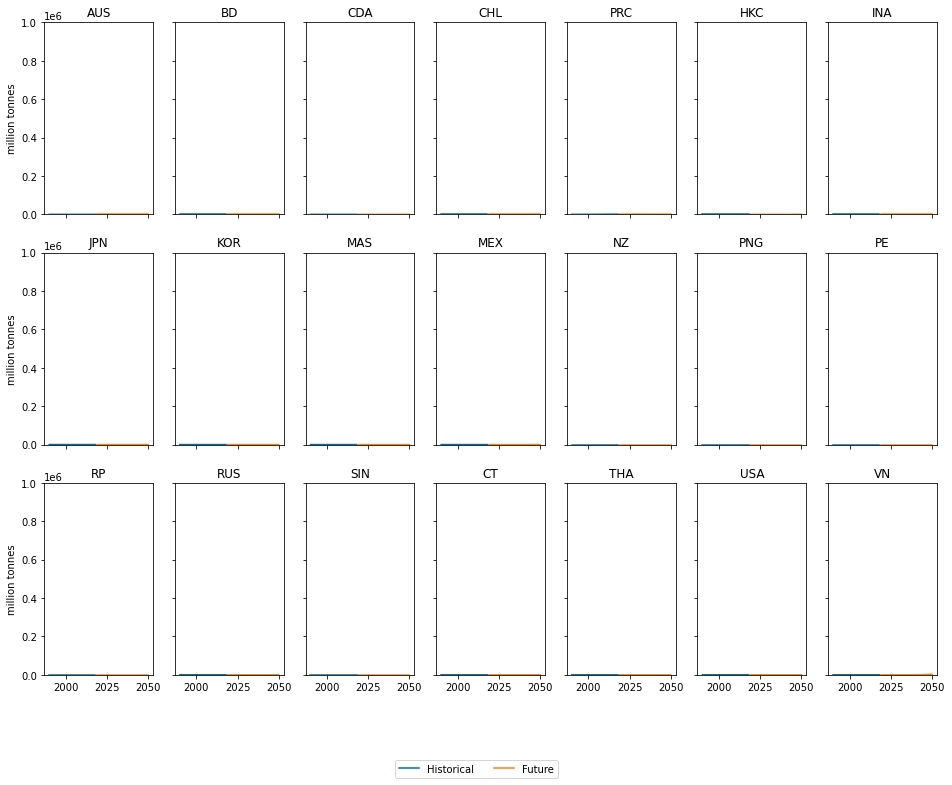

Figure saved as results\Industry\steel\steel production.png

FINISHED. -- Current date/time: 2020-10-19 14:52:06

esultsproduction demand saved in the folder Industry\steel


In [8]:
# RunRegressions.py
# create linear regrssion models for all 21 economies

# import libraries
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import sys

from matplotlib.ticker import MultipleLocator, FixedLocator, FixedFormatter

print("Script started. -- Current date/time:", dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# import regression functions from RegressionFunctions.py
sys.path.insert(0, 'Common')
from CommonFunctions import run_regression, run_prediction, plot2

# Perform regressions
# read in data from csv
SteelHistoricalPrepared = pd.read_csv(r'modified\SteelHistoricalPrepared.csv')
GDPPop8thFuturePrepared = pd.read_csv(r'modified\GDPPop8thFuturePrepared.csv')

# get list of economies and create economy-model pairs
economies = SteelHistoricalPrepared.Economy.unique()
models = {economy: LinearRegression() for economy in economies}

# set Economy as index 
df1 = SteelHistoricalPrepared.set_index('Economy')
# set explanatory variable x and dependent variable y
x = ['Year','lnGDPpercap'] # data that has relationship with y
y = ['lnPROpercap'] # what you want to know

# run regression
SteelRegressionModel = run_regression(models, economies, df1, x, y)

print('\nGenerated regression. Please wait for plotting.\n')

# make predictions using historical values of GDP per capita
HistoricalX = df1[['Year','lnGDPpercap']]
ResultsColumn = ['Predicted Steel Production per capita']
HistoricalPredictionResults = run_prediction(SteelRegressionModel, economies, HistoricalX, ResultsColumn)

# make predictions using FUTURE values of GDP per capita
FutureX = GDPPop8thFuturePrepared.set_index('Economy')[['Year','lnGDPpercap']]
FuturePredictionResults = run_prediction(SteelRegressionModel, economies, FutureX, ResultsColumn)

# -- Compute steel production (instead of per capita)
# read historical and future population data from csv
Pop8thHistorical = pd.read_csv(r'..\Macro\results\Pop8thHistorical.csv')
Pop8thFuture = pd.read_csv(r'..\Macro\results\Pop8thFuture.csv')

# add population column to historical and future prediction results
HistoricalPredictionResults = pd.merge(HistoricalPredictionResults, Pop8thHistorical, how='left', on=['Economy','Year'])
FuturePredictionResults = pd.merge(FuturePredictionResults,Pop8thFuture, how='left',on=['Economy','Year'])

# compute steel production
# Jan 16 2020: delete 'div(1000)' because I want thousand tons for my list
# HistoricalPredictionResults['Predicted Steel Production'] = HistoricalPredictionResults['Predicted Steel Production per capita'].mul(HistoricalPredictionResults['Population']).div(1000)
# FuturePredictionResults['Predicted Steel Production'] = FuturePredictionResults['Predicted Steel Production per capita'].mul(FuturePredictionResults['Population']).div(1000)
HistoricalPredictionResults['Predicted Steel Production'] = HistoricalPredictionResults['Predicted Steel Production per capita'].mul(HistoricalPredictionResults['Population'])
FuturePredictionResults['Predicted Steel Production'] = FuturePredictionResults['Predicted Steel Production per capita'].mul(FuturePredictionResults['Population'])

# combine results
SteelResultsCombined = pd.concat([HistoricalPredictionResults,FuturePredictionResults])

# write results to csv
HistoricalPredictionResults.to_csv(r'results\HistoricalPredictionResults.csv', index=False)
FuturePredictionResults.to_csv(r'results\FuturePredictionResults.csv', index=False)
SteelResultsCombined.to_csv(r'results\SteelResultsCombined.csv', index=False)

print("Results are saved. -- Current date/time:", dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# STEP 6 - plot results
# set file name
# Use sharex and sharey = True or False to share those axes
figurename = r'results\Industry\steel\steel production.png'
Plotylabel = 'million tonnes'
sharex = True
sharey = True

# create dataframe with Historical results in one column and Future in another
df1 = HistoricalPredictionResults.drop(['Predicted Steel Production per capita','Population'], axis=1)
df2 = FuturePredictionResults.drop(['Predicted Steel Production per capita','Population'], axis=1)
df1.rename(columns={'Predicted Steel Production':'Historical'},inplace=True)
df2.rename(columns={'Predicted Steel Production':'Future'},inplace=True)
dfPlot = pd.merge(df1,df2,how='outer')

# Create the figure
# plot2 is a function from CommonFunctions.py
print('Preparing to show the figure...')
plot2(economies, dfPlot, figurename, Plotylabel, sharex, sharey)
print('Figure saved as %s' % figurename)

# Finished
print("\nFINISHED. -- Current date/time:", dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('\nSteel production demand saved in the folder Industry\steel\results')

C:\Users\mathew.horne\Projects\Industry_8th\env\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


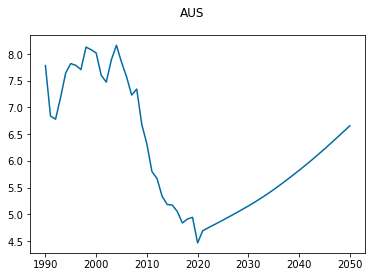

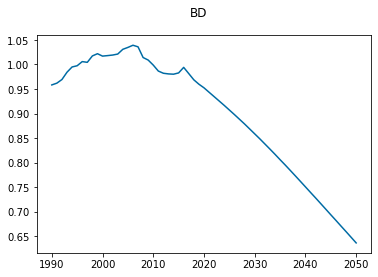

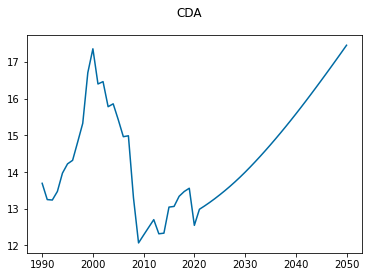

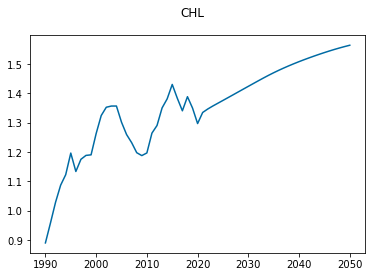

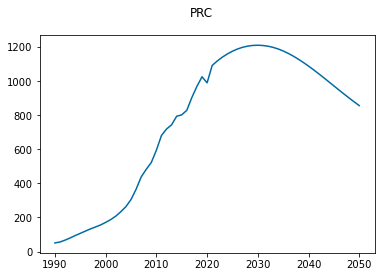

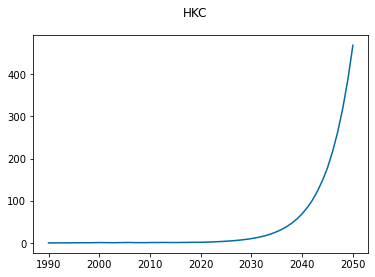

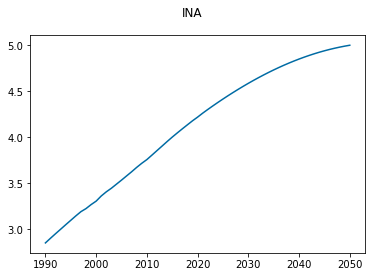

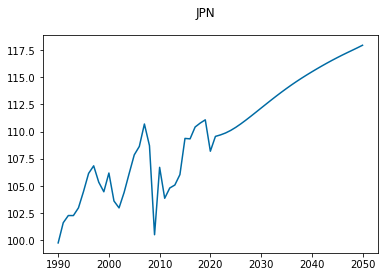

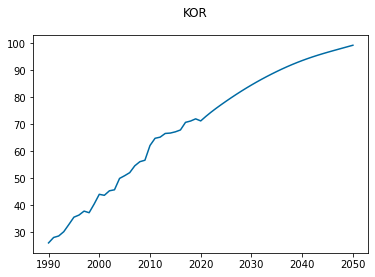

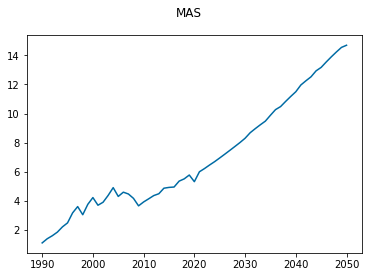

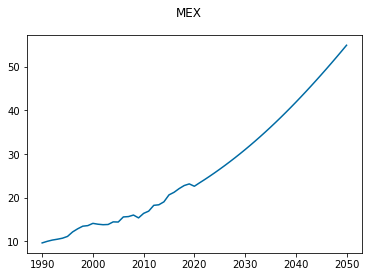

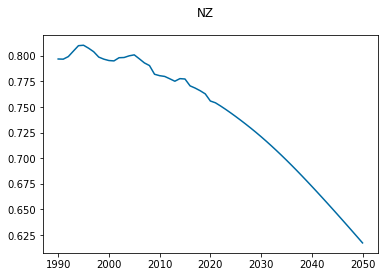

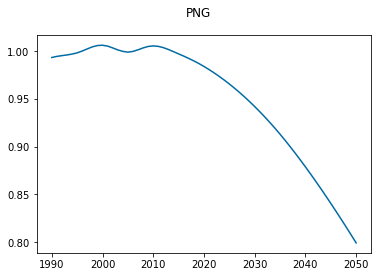

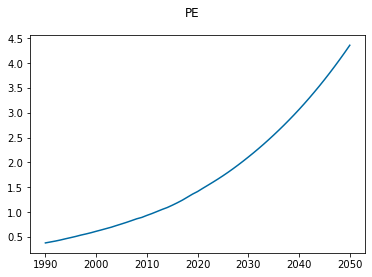

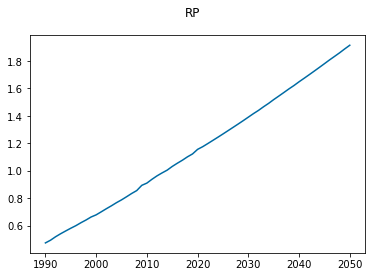

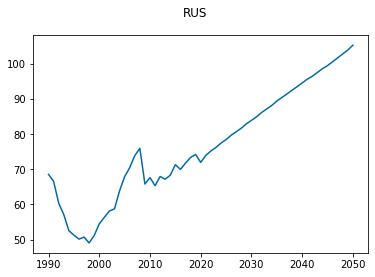

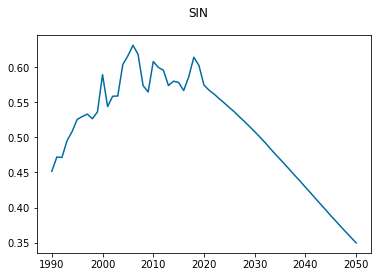

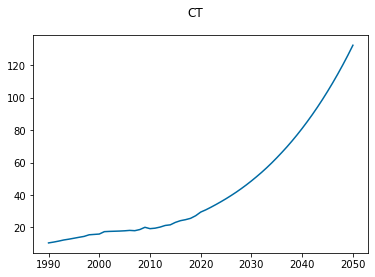

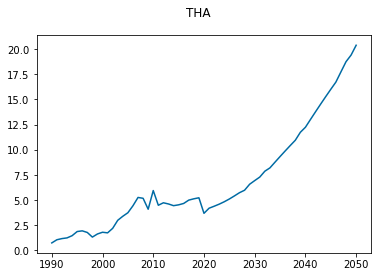

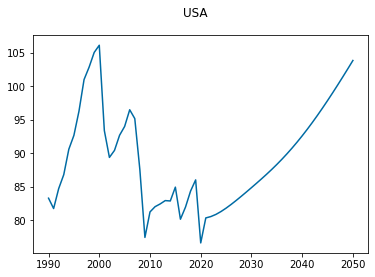

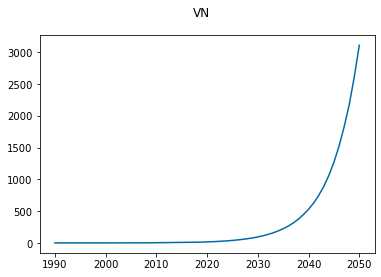

In [51]:
TEST = SteelResultsCombined.set_index(['Economy', 'Year'])

for economy in SteelHistoricalPrepared.Economy.unique():
    fig, axs = plt.subplots(1)
    _df = TEST.loc[economy]
    axs = plt.plot('Predicted Steel Production', data = _df)
    fig.suptitle(economy)
    plt.savefig('./results/Industry/steel/' + economy + '.png')

In [34]:
print(x[2])

IndexError: list index out of range

In [5]:
?plot2

Signature: plot2(economies, df, figurename, Plotylabel, sharex, sharey)
Docstring: <no docstring>
File:      c:\users\mathew.horne\projects\industry_8th\notebooks\31_is\commonfunctions.py
Type:      function
